In [3]:
dnn_attack_intensity = 9

In [4]:
from models.ae import AE
from models.vae import VAE
from models.rnn import RNN
from models.dnn import DNN
from models.dnnAE import DNN as DNNAE


import torch
import torch.nn.functional as F

from sklearn import metrics

import re
import os
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from collections import defaultdict
from pandas import DataFrame, concat
from matplotlib.ticker import FormatStrFormatter

In [5]:
seed = 41
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [7]:
# vae parameter
latent_dim = 118
# rnn parameter
hidden_size = 100
num_layers = 2
rnn_window = 10
# proposed model parameter
samples = 30
# ae parameter
no_residuals = 1

# predictions
pred = defaultdict(dict)
y = defaultdict()
no_signal = defaultdict()

# **DNN Data Generation**

## **Load Sensor and Residual Data**

In [9]:
Z, RES = defaultdict(dict), defaultdict(dict)
for severity in tqdm(range(5,10), desc='Reading data ... '):
    ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{severity}')
    for filename in os.listdir(ATTACK_DATA_PATH):
        fname = os.path.join(ATTACK_DATA_PATH, filename)
        data = loadmat(fname)
        att_type = int(re.findall(r'\d+', filename)[0])
        Z[severity][att_type] = data['Z']
        RES[severity][att_type] = data['Res']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']
RES[0] = data['Res']

Z = dict(sorted(Z.items()))
RES = dict(sorted(RES.items()))

Reading data ... : 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


## **Load Trained Models**

In [10]:
noise_levels = [0, 5, 10, 20, 50]
vaes, rnns, aes = dict(), dict(), dict()
# load vae, rnn, ae trained model based on noise levels
for level in noise_levels:
    vae = VAE(latent_dim).to(device)
    vae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'vae_{level}%.pt')))
    vaes[level] = vae

    rnn = RNN(input_dims=rnn_window * latent_dim,
              outputdims=latent_dim,
              hidden_size=hidden_size,
              num_layers=num_layers).to(device)
    rnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'rnn_{level}%.pt')))
    rnns[level] = rnn

    ae = AE(latent_dim).to(device)
    ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'ae_{level}%.pt')))
    aes[level] = ae

# load dnn and dnnAE trained using normal data and attack severity dnn_attack_intensity attack data
dnn = DNN().to(device)
dnn.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnn_{dnn_attack_intensity}.pt')))

dnnAE = DNNAE(no_residuals=no_residuals).to(device)
dnnAE.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, f'dnnAE_{dnn_attack_intensity}.pt')))

<All keys matched successfully>

## **VAE+RNN --> DNN Data Generation**

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### **Normal Sensor Data To DNN Data**

In [12]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    # state estimation residual for normal data
    r1 = torch.tensor(RES[0], dtype=torch.float32)
    R = []
    for _ in range(samples):
        # VAE residuals for normal data
        z_rec = vae(z)
        r2 = (z_rec - z).detach().cpu()

        # rnn prediction residual
        s_t = vae.encoder(z).cpu().detach().numpy()
        s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
        s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
        z_rnn = vae.decoder(rnn(s_t))
        r3 = (z_rnn - z[rnn_window:]).detach().cpu()
        R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
    pred_normal[level] = dnn(torch.stack(R, dim=1).to(device)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]


### **Attack Sensor Data To DNN Data**

In [13]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    vae = vaes[level].eval()
    rnn = rnns[level].eval()
    for severity in range(5,10):
        _Z, _RES = Z[severity], RES[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            # state estimation residual
            r1 = torch.tensor(_RES[k], dtype=torch.float32)
            z = torch.tensor(v, dtype=torch.float32).to(device)
            _R = []
            for _ in range(samples):
                # VAE residuals
                z_rec = vae(z)
                r2 = (z_rec - z).detach().cpu()
                
                # rnn prediction residual
                s_t = vae.encoder(z).cpu().detach().numpy()
                s_t = series_to_supervised(s_t, n_in=rnn_window).values[:,:rnn_window * latent_dim]
                s_t = torch.tensor(s_t, dtype=torch.float32).to(device)
                z_rnn = vae.decoder(rnn(s_t))
                r3 = (z_rnn - z[rnn_window:]).detach().cpu()
                _R.append(torch.stack([r1[rnn_window:],r2[rnn_window:],r3], dim=1))
            R[k] = torch.stack(_R, dim=1)
        R = dict(sorted(R.items()))
        _pred = dnn(torch.cat(list(R.values()), dim=0).to(device))
        pred['vae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [05:53<00:00, 70.79s/it]


### **Target Data**

In [14]:
_y = []
no_signal['vae'] = len(Z[0]) - rnn_window
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['vae']), dtype=torch.long), num_classes=4))
y['vae'] = torch.cat(_y, dim=0)

## **AE --> DNN Data Generation**

### **Normal Sensor Data To DNN Data**

In [15]:
pred_normal = defaultdict()
z = torch.tensor(Z[0], dtype=torch.float32).to(device)
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    # AE residuals for normal data
    r = (ae(z) - z)
    pred_normal[level] = dnnAE(torch.stack([r], dim=1)).detach().cpu()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 1075.08it/s]


### **Attack Sensor Data To DNN Data**

In [16]:
for level in tqdm(noise_levels, desc=' Generating residuals ... '):
    ae = aes[level].eval()
    for severity in range(5,10):
        _Z = Z[severity]
        R = defaultdict(list)
        for k, v in _Z.items():
            z = torch.tensor(v, dtype=torch.float32).to(device)
            # AE residuals
            r = (ae(z) - z).detach().cpu()
            R[k] = torch.stack([r], dim=1)
        R = dict(sorted(R.items()))
        _pred = dnnAE(torch.cat(list(R.values()), dim=0).to(device))
        pred['ae'][level,severity] = torch.cat([pred_normal[level].cpu(), _pred.cpu()], dim=0).detach()

 Generating residuals ... : 100%|██████████| 5/5 [00:00<00:00, 13.74it/s]


### **Target Data**

In [17]:
_y = []
no_signal['ae'] = len(Z[0])
for l in range(4):
    _y.append(F.one_hot(l * torch.ones((no_signal['ae']), dtype=torch.long), num_classes=4))
y['ae'] = torch.cat(_y, dim=0)

# **DNN Evaluation**

## **Confusion Matrices**

### **Confusion Matrix: Noise Level 0%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  0.998780  0.999237      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.997869  1.000000  0.998933      3278

    accuracy                       0.999390     13112
   macro avg   0.999391  0.999390  0.999390     13112
weighted avg   0.999391  0.999390  0.999390     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999696  1.000000  0.999848      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.982666  1.000000  0.991257      3288
           3   1.000000  0.982664  0.991256      3288

    accuracy                       0.995514     13152
   macro avg   0.995590  0.995514  0.995514     13152
weighted avg   0.995590  0.995514  0.995514     13152

Confusion Matrix:


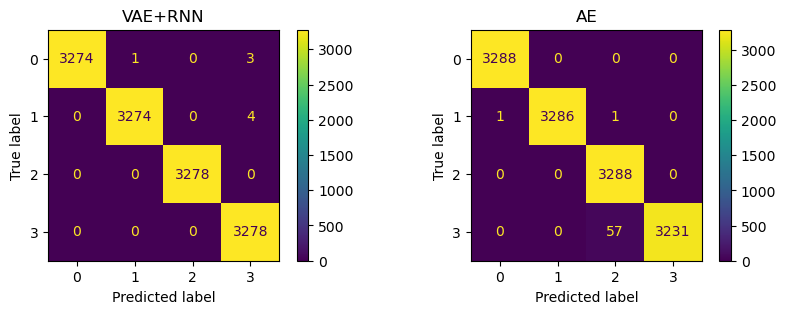

ROC Curve:


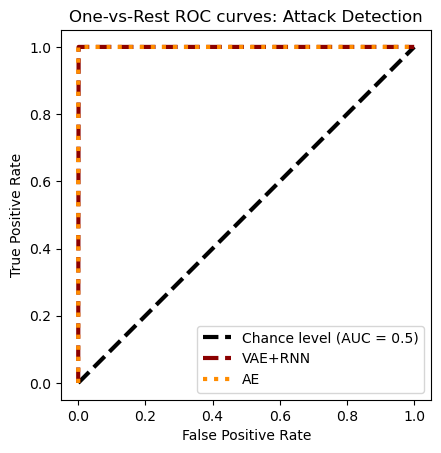

In [18]:
severity = 5
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.997573  1.000000  0.998785      3288
           3   1.000000  0.997567  0.998782      3288

    accuracy                       0.999392     13152
   macro avg   0.999393  0.999392  0.999392     13152
weighted avg   0.999393  0.999392  0.999392     13152

Confusion Matrix:


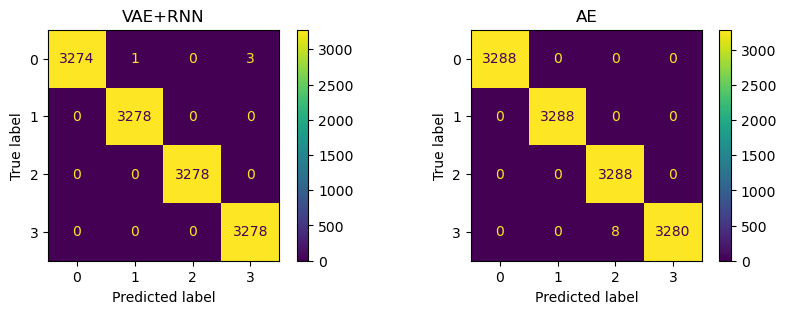

ROC Curve:


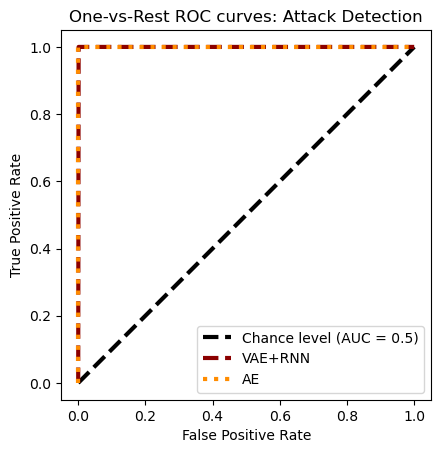

In [19]:
severity = 6
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


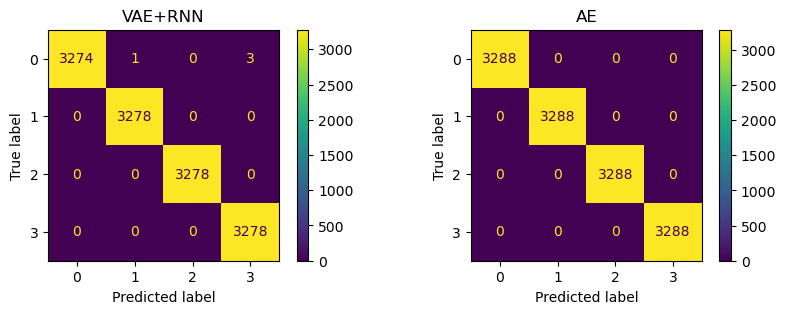

ROC Curve:


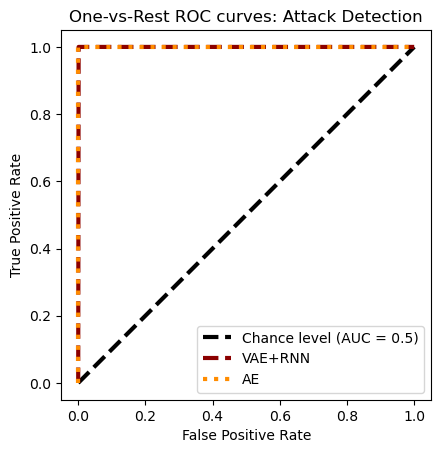

In [20]:
severity = 7
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


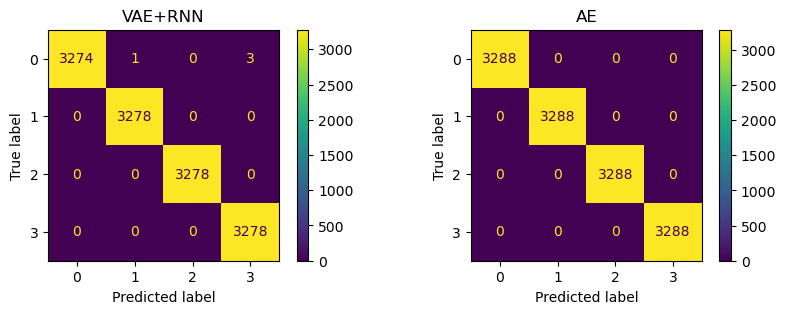

ROC Curve:


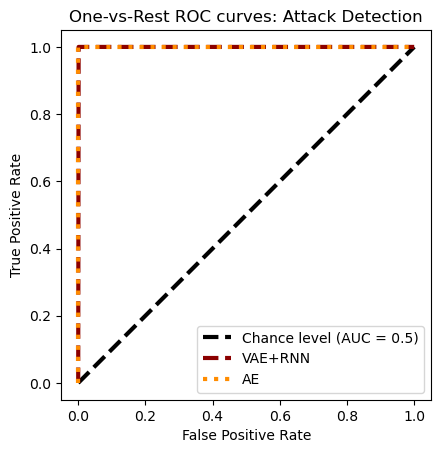

In [21]:
severity = 8
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.997562  0.998780  0.998171      3278
           1   0.999695  0.999390  0.999542      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999084  0.998170  0.998627      3278

    accuracy                       0.999085     13112
   macro avg   0.999085  0.999085  0.999085     13112
weighted avg   0.999085  0.999085  0.999085     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  1.000000  1.000000      3288

    accuracy                       1.000000     13152
   macro avg   1.000000  1.000000  1.000000     13152
weighted avg   1.000000  1.000000  1.000000     13152

Confusion Matrix:


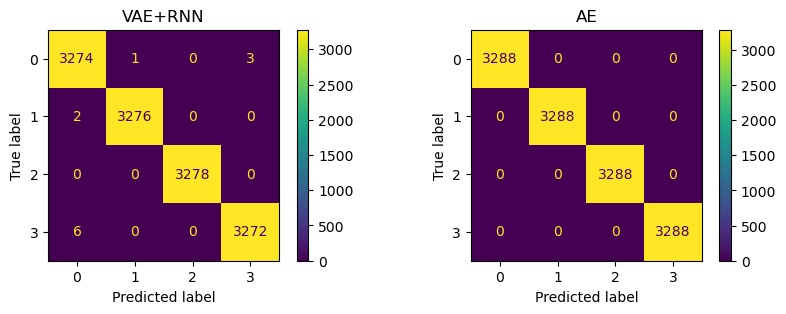

ROC Curve:


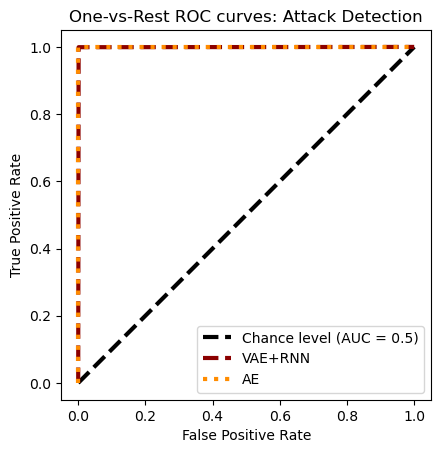

In [22]:
severity = 9
level = 0

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 5%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  0.998780  0.999237      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.998173  1.000000  0.999086      3278

    accuracy                       0.999390     13112
   macro avg   0.999391  0.999390  0.999390     13112
weighted avg   0.999391  0.999390  0.999390     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999660  0.893856  0.943802      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.893478  1.000000  0.943743      3288
           3   0.892791  0.881387  0.887052      3288

    accuracy                       0.943659     13152
   macro avg   0.946482  0.943659  0.943573     13152
weighted avg   0.946482  0.943659  0.943573     13152

Confusion Matrix:


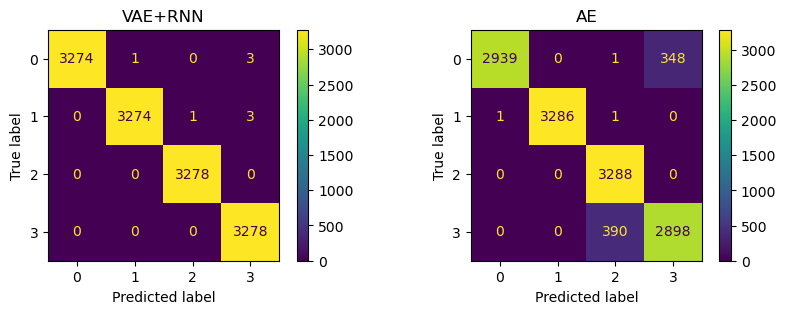

ROC Curve:


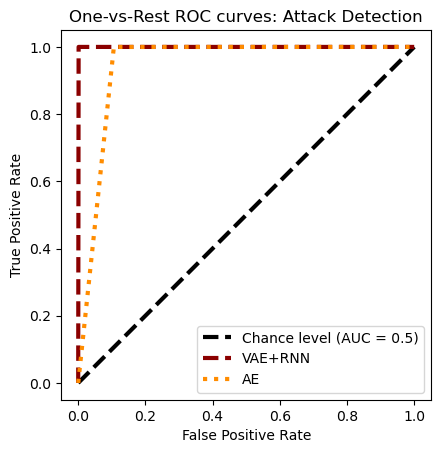

In [23]:
severity = 5
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.987899  0.893856  0.938528      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.921525  1.000000  0.959160      3288
           3   0.895212  0.904197  0.899682      3288

    accuracy                       0.949513     13152
   macro avg   0.951159  0.949513  0.949342     13152
weighted avg   0.951159  0.949513  0.949342     13152

Confusion Matrix:


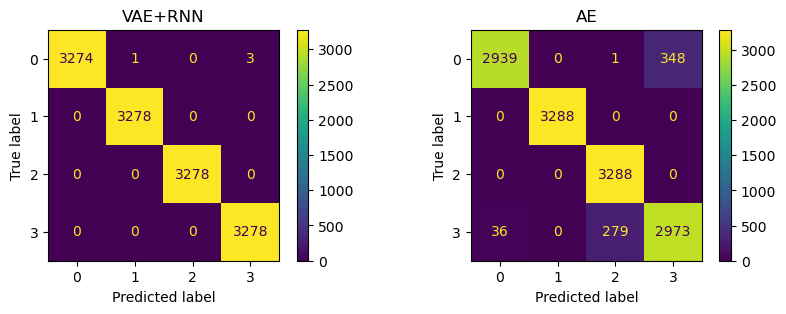

ROC Curve:


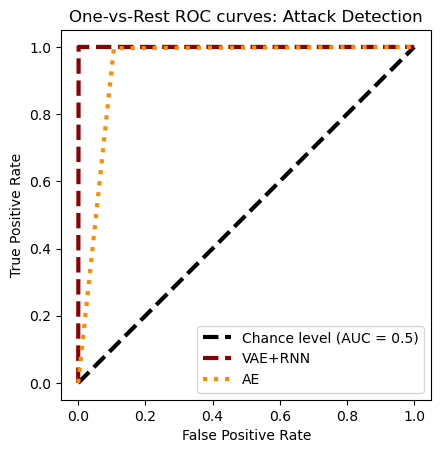

In [24]:
severity = 6
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.859860  0.893856  0.876528      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.946187  1.000000  0.972350      3288
           3   0.882868  0.797749  0.838153      3288

    accuracy                       0.922901     13152
   macro avg   0.922229  0.922901  0.921758     13152
weighted avg   0.922229  0.922901  0.921758     13152

Confusion Matrix:


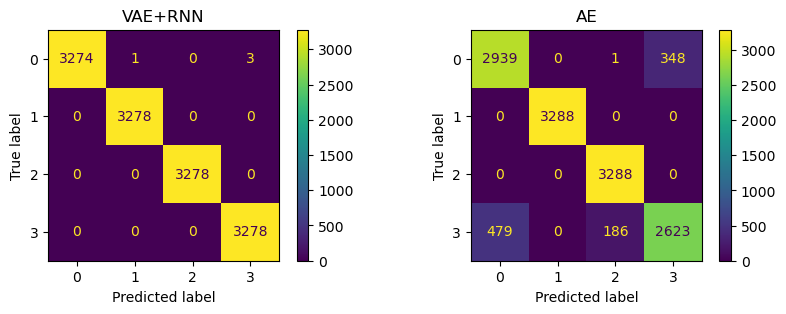

ROC Curve:


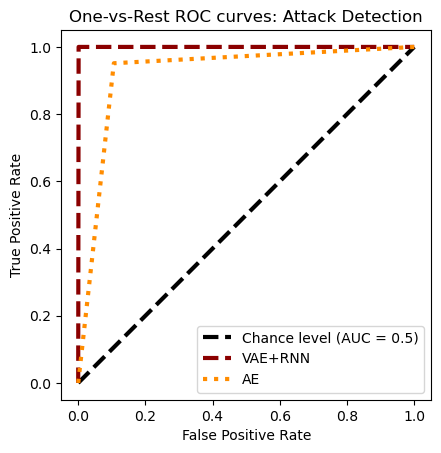

In [25]:
severity = 7
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.998780  0.999389      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999695     13112
   macro avg   0.999695  0.999695  0.999695     13112
weighted avg   0.999695  0.999695  0.999695     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.669171  0.893856  0.765365      3288
           1   1.000000  1.000000  1.000000      3288
           2   0.962811  1.000000  0.981053      3288
           3   0.830822  0.519769  0.639476      3288

    accuracy                       0.853406     13152
   macro avg   0.865701  0.853406  0.846473     13152
weighted avg   0.865701  0.853406  0.846473     13152

Confusion Matrix:


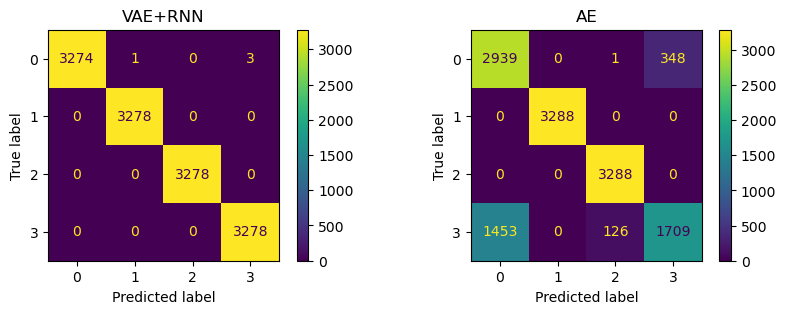

ROC Curve:


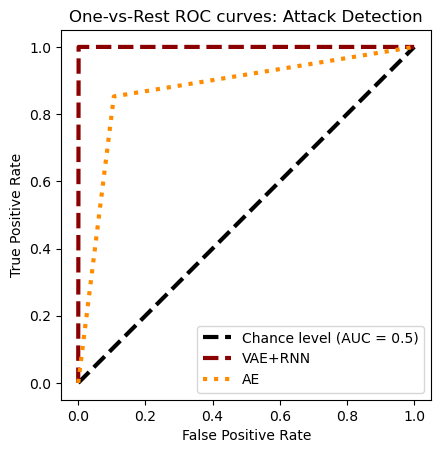

In [26]:
severity = 8
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.997562  0.998780  0.998171      3278
           1   0.999695  0.999390  0.999542      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999084  0.998170  0.998627      3278

    accuracy                       0.999085     13112
   macro avg   0.999085  0.999085  0.999085     13112
weighted avg   0.999085  0.999085  0.999085     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.502823  0.893856  0.643600      3288
           1   1.000000  0.611010  0.758543      3288
           2   0.934478  0.628954  0.751863      3288
           3   0.402593  0.377737  0.389769      3288

    accuracy                       0.627889     13152
   macro avg   0.709974  0.627889  0.635944     13152
weighted avg   0.709974  0.627889  0.635944     13152

Confusion Matrix:


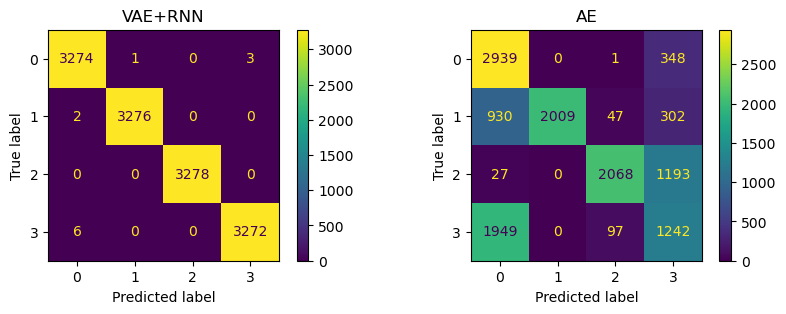

ROC Curve:


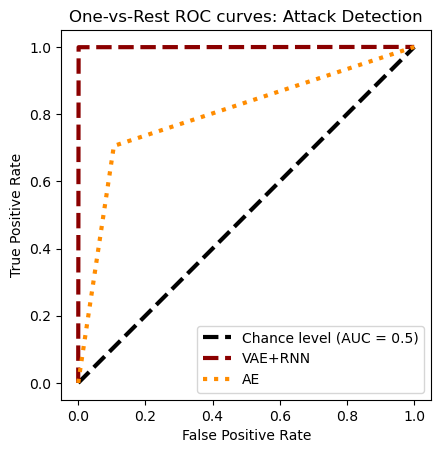

In [27]:
severity = 9
level = 5

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 10%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999390  0.999695      3278
           1   0.999695  0.998780  0.999237      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.998781  1.000000  0.999390      3278

    accuracy                       0.999542     13112
   macro avg   0.999543  0.999542  0.999542     13112
weighted avg   0.999543  0.999542  0.999542     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.990473  0.853710  0.917021      3288
           1   0.998481  0.999392  0.998936      3288
           2   0.844376  1.000000  0.915622      3288
           3   0.851899  0.811740  0.831335      3288

    accuracy                       0.916210     13152
   macro avg   0.921307  0.916210  0.915728     13152
weighted avg   0.921307  0.916210  0.915728     13152

Confusion Matrix:


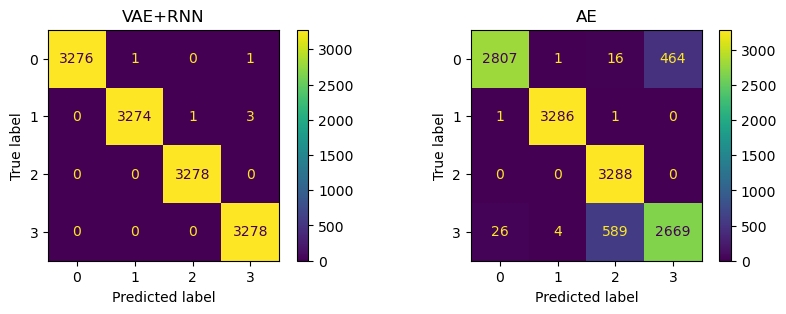

ROC Curve:


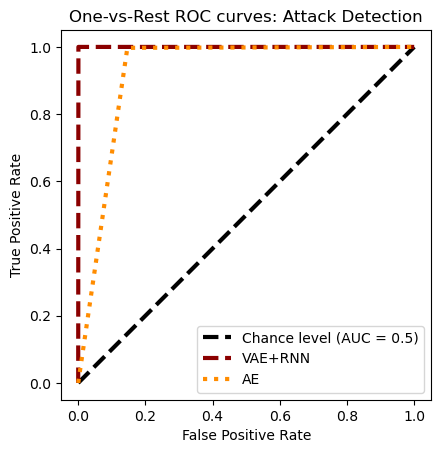

In [28]:
severity = 5
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999390  0.999695      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999695  1.000000  0.999847      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.959002  0.853710  0.903298      3288
           1   0.998179  1.000000  0.999088      3288
           2   0.882685  1.000000  0.937687      3288
           3   0.855271  0.833942  0.844472      3288

    accuracy                       0.921913     13152
   macro avg   0.923784  0.921913  0.921136     13152
weighted avg   0.923784  0.921913  0.921136     13152

Confusion Matrix:


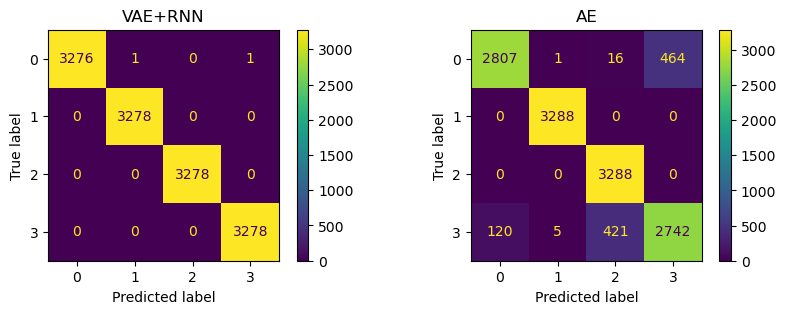

ROC Curve:


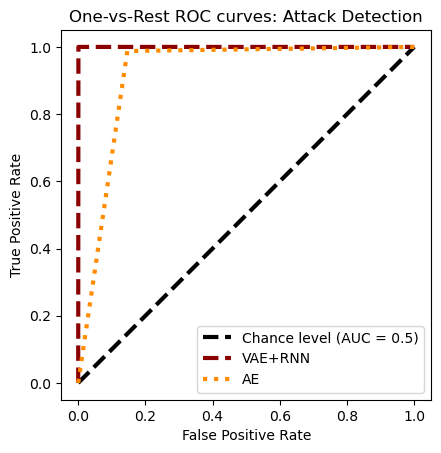

In [29]:
severity = 6
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999390  0.999695      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999695  1.000000  0.999847      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.853710  0.853710  0.853710      3288
           1   0.990660  1.000000  0.995308      3288
           2   0.907535  1.000000  0.951527      3288
           3   0.841205  0.747567  0.791626      3288

    accuracy                       0.900319     13152
   macro avg   0.898278  0.900319  0.898043     13152
weighted avg   0.898278  0.900319  0.898043     13152

Confusion Matrix:


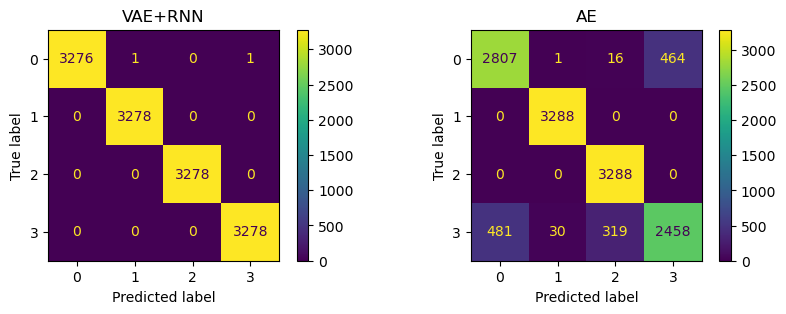

ROC Curve:


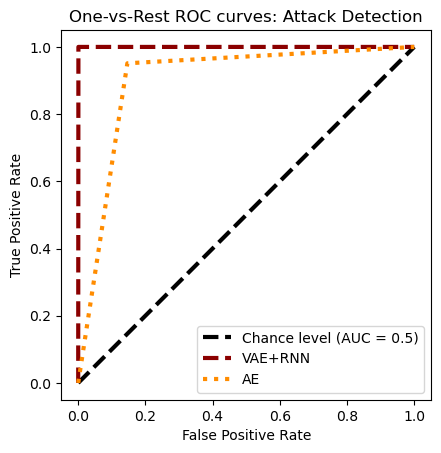

In [30]:
severity = 7
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999390  0.999695      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999695  1.000000  0.999847      3278

    accuracy                       0.999847     13112
   macro avg   0.999848  0.999847  0.999847     13112
weighted avg   0.999848  0.999847  0.999847     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.738684  0.853710  0.792043      3288
           1   0.966774  1.000000  0.983107      3288
           2   0.925634  0.999392  0.961100      3288
           3   0.805914  0.588504  0.680260      3288

    accuracy                       0.860401     13152
   macro avg   0.859252  0.860401  0.854127     13152
weighted avg   0.859252  0.860401  0.854127     13152

Confusion Matrix:


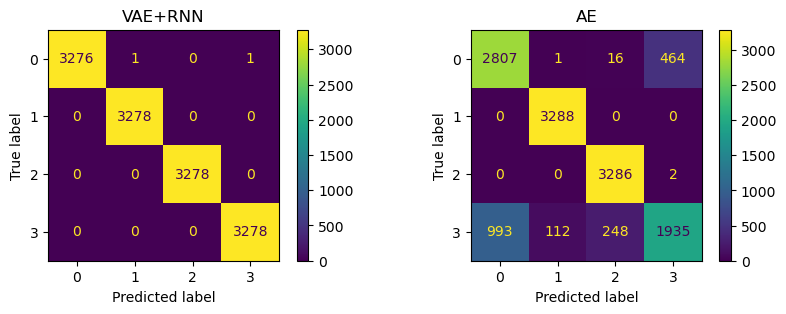

ROC Curve:


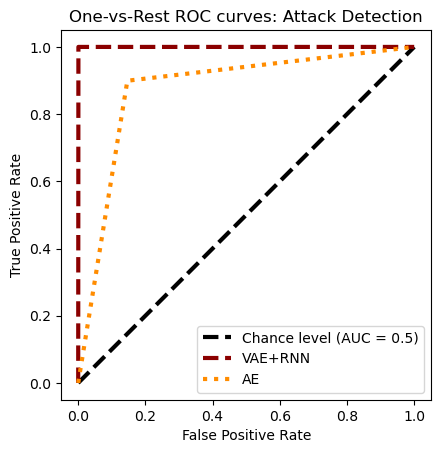

In [31]:
severity = 8
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.995140  0.999390  0.997260      3278
           1   0.999695  0.999390  0.999542      3278
           2   1.000000  1.000000  1.000000      3278
           3   0.999694  0.995729  0.997707      3278

    accuracy                       0.998627     13112
   macro avg   0.998632  0.998627  0.998628     13112
weighted avg   0.998632  0.998627  0.998628     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.631923  0.853710  0.726261      3288
           1   0.932018  0.934002  0.933009      3288
           2   0.877138  0.686131  0.769966      3288
           3   0.509673  0.440693  0.472680      3288

    accuracy                       0.728634     13152
   macro avg   0.737688  0.728634  0.725479     13152
weighted avg   0.737688  0.728634  0.725479     13152

Confusion Matrix:


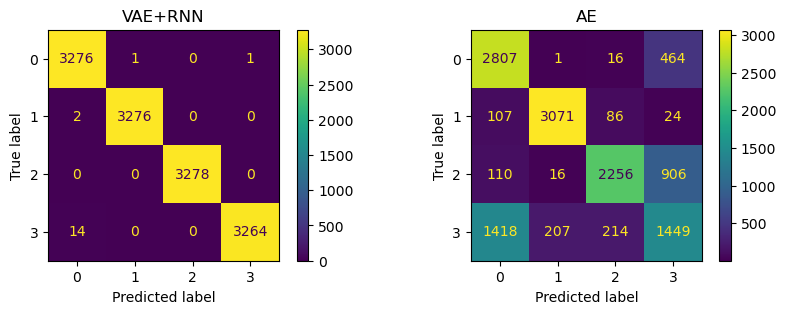

ROC Curve:


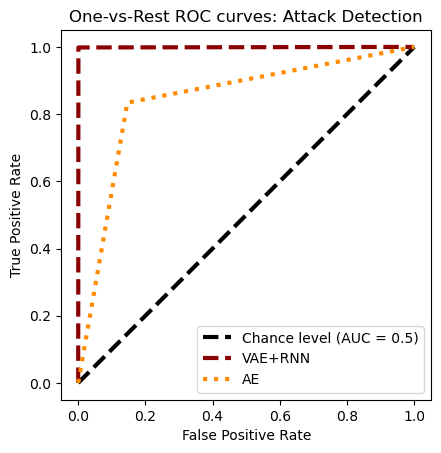

In [32]:
severity = 9
level = 10

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 20%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  0.998780  0.999237      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999619     13112
   macro avg   0.999619  0.999619  0.999619     13112
weighted avg   0.999619  0.999619  0.999619     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999696  0.999696  0.999696      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.999696  1.000000  0.999848      3288
           3   0.999696  1.000000  0.999848      3288

    accuracy                       0.999772     13152
   macro avg   0.999772  0.999772  0.999772     13152
weighted avg   0.999772  0.999772  0.999772     13152

Confusion Matrix:


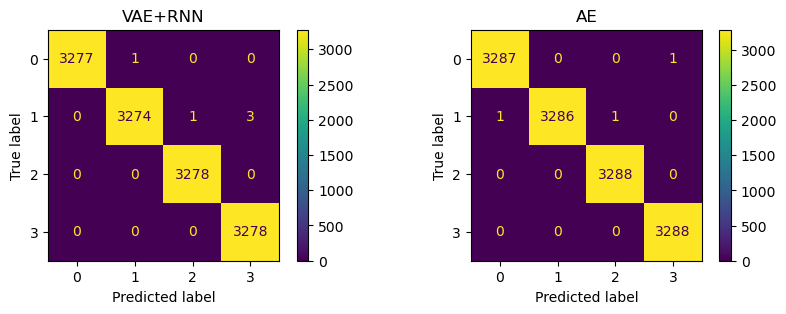

ROC Curve:


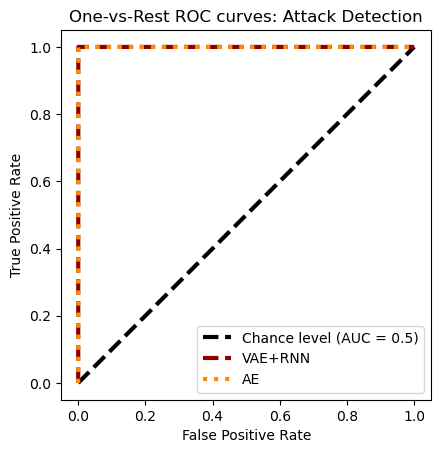

In [33]:
severity = 5
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999924     13112
   macro avg   0.999924  0.999924  0.999924     13112
weighted avg   0.999924  0.999924  0.999924     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.989762  0.999696  0.994704      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999693  0.989659  0.994651      3288

    accuracy                       0.997339     13152
   macro avg   0.997364  0.997339  0.997339     13152
weighted avg   0.997364  0.997339  0.997339     13152

Confusion Matrix:


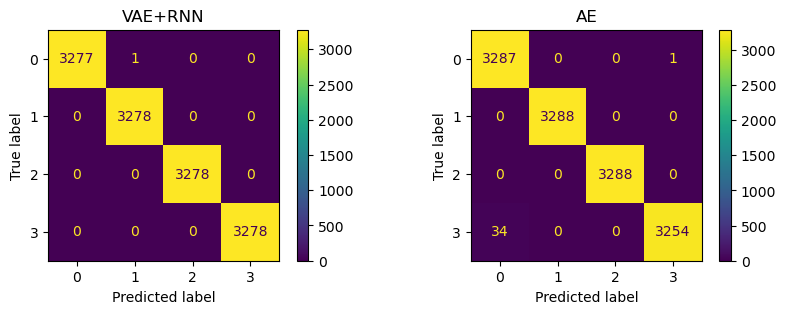

ROC Curve:


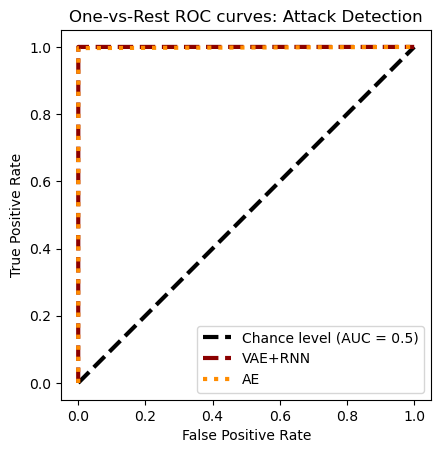

In [34]:
severity = 6
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999924     13112
   macro avg   0.999924  0.999924  0.999924     13112
weighted avg   0.999924  0.999924  0.999924     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.801512  0.999696  0.889701      3288
           1   0.989170  1.000000  0.994555      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999590  0.741484  0.851406      3288

    accuracy                       0.935295     13152
   macro avg   0.947568  0.935295  0.933915     13152
weighted avg   0.947568  0.935295  0.933915     13152

Confusion Matrix:


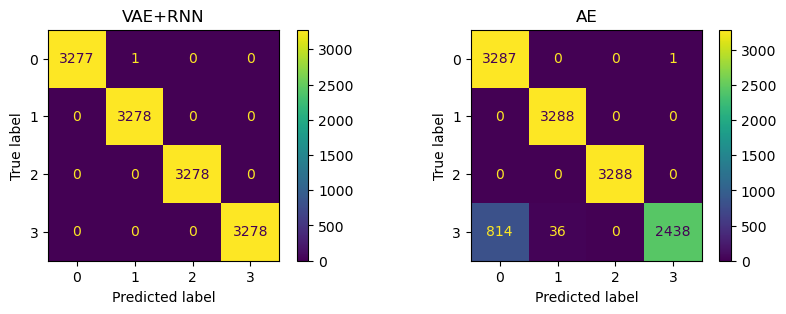

ROC Curve:


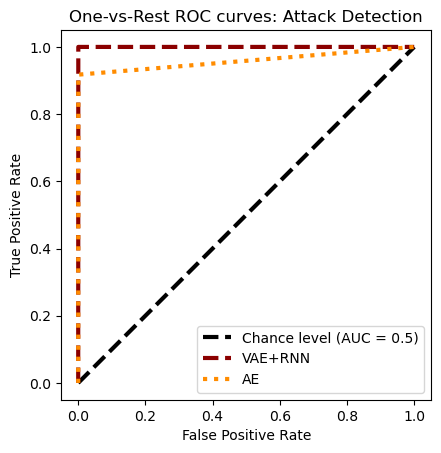

In [35]:
severity = 7
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999924     13112
   macro avg   0.999924  0.999924  0.999924     13112
weighted avg   0.999924  0.999924  0.999924     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.603009  0.999696  0.752260      3288
           1   0.971344  1.000000  0.985464      3288
           2   1.000000  1.000000  1.000000      3288
           3   0.999027  0.312348  0.475904      3288

    accuracy                       0.828011     13152
   macro avg   0.893345  0.828011  0.803407     13152
weighted avg   0.893345  0.828011  0.803407     13152

Confusion Matrix:


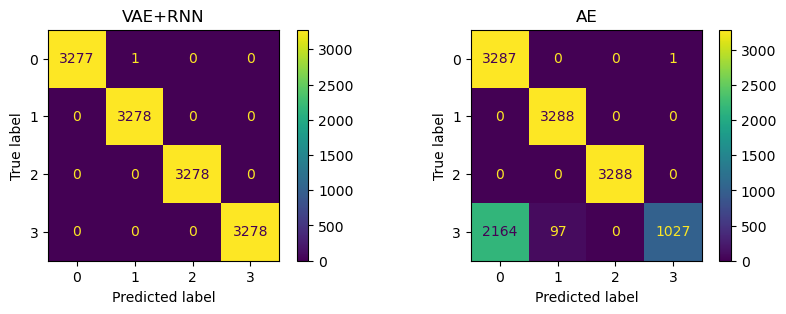

ROC Curve:


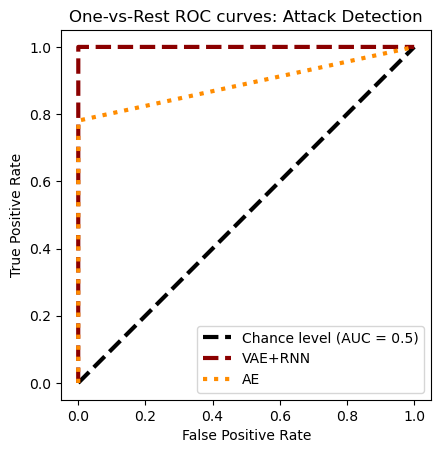

In [36]:
severity = 8
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.917927  0.999695  0.957068      3278
           1   0.999695  0.998780  0.999237      3278
           2   1.000000  0.999695  0.999847      3278
           3   1.000000  0.912142  0.954052      3278

    accuracy                       0.977578     13112
   macro avg   0.979405  0.977578  0.977551     13112
weighted avg   0.979405  0.977578  0.977551     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.518782  0.999696  0.683084      3288
           1   0.950709  0.897506  0.923342      3288
           2   1.000000  0.274939  0.431298      3288
           3   0.156339  0.133516  0.144029      3288

    accuracy                       0.576414     13152
   macro avg   0.656457  0.576414  0.545438     13152
weighted avg   0.656457  0.576414  0.545438     13152

Confusion Matrix:


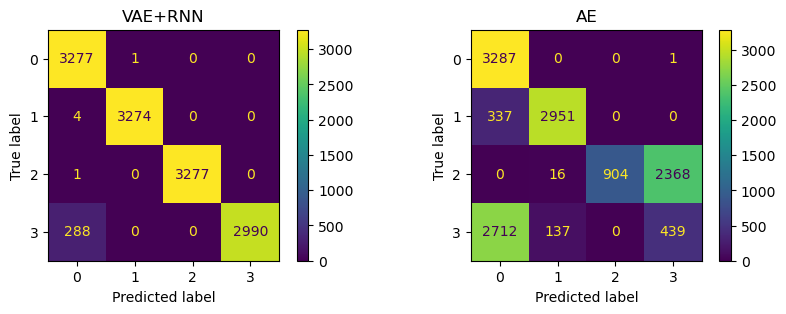

ROC Curve:


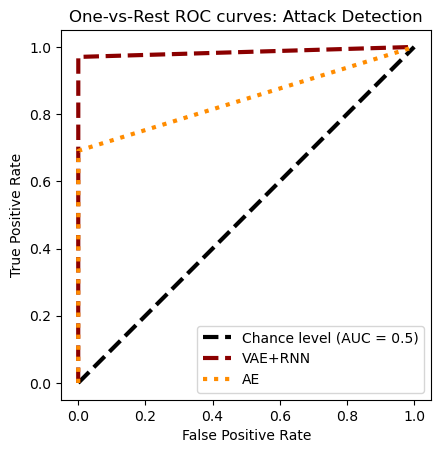

In [37]:
severity = 9
level = 20

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

### **Confusion Matrix: Noise Level 50%**

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  0.998780  0.999237      3278
           2   0.999695  1.000000  0.999847      3278
           3   0.999086  1.000000  0.999543      3278

    accuracy                       0.999619     13112
   macro avg   0.999619  0.999619  0.999619     13112
weighted avg   0.999619  0.999619  0.999619     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.999392  1.000000  0.999696      3288
           1   1.000000  0.999392  0.999696      3288
           2   0.999696  1.000000  0.999848      3288
           3   1.000000  0.999696  0.999848      3288

    accuracy                       0.999772     13152
   macro avg   0.999772  0.999772  0.999772     13152
weighted avg   0.999772  0.999772  0.999772     13152

Confusion Matrix:


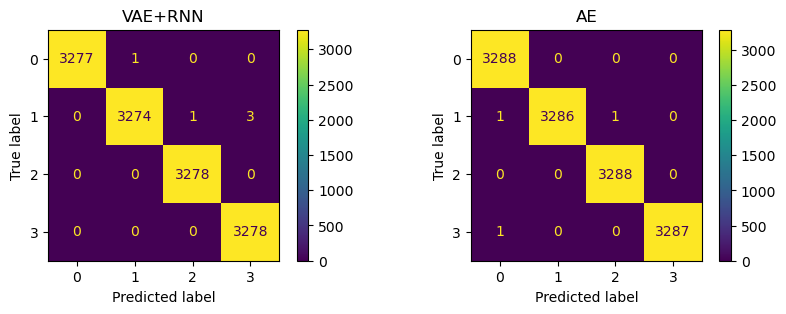

ROC Curve:


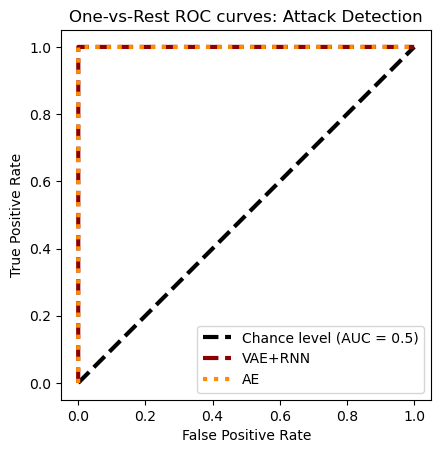

In [38]:
severity = 5
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999924     13112
   macro avg   0.999924  0.999924  0.999924     13112
weighted avg   0.999924  0.999924  0.999924     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.962529  1.000000  0.980907      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.961071  0.980149      3288

    accuracy                       0.990268     13152
   macro avg   0.990632  0.990268  0.990264     13152
weighted avg   0.990632  0.990268  0.990264     13152

Confusion Matrix:


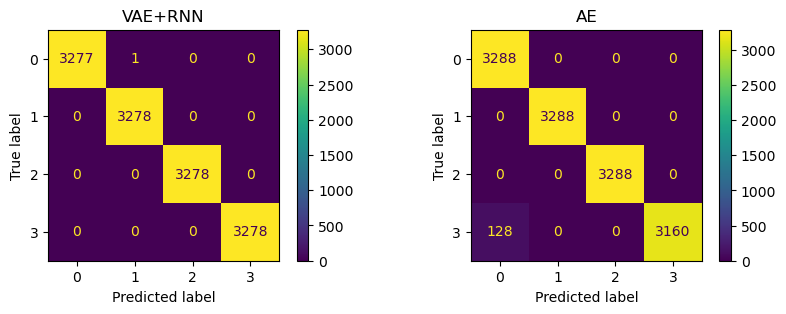

ROC Curve:


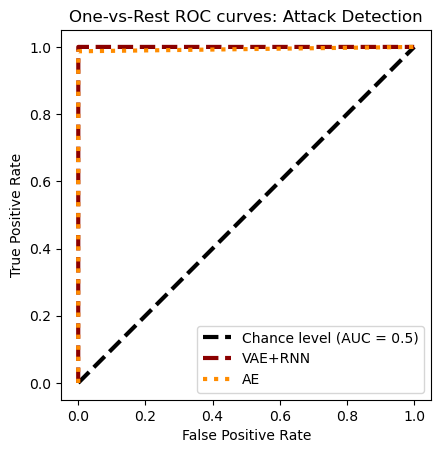

In [39]:
severity = 6
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999924     13112
   macro avg   0.999924  0.999924  0.999924     13112
weighted avg   0.999924  0.999924  0.999924     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.710765  1.000000  0.830933      3288
           1   1.000000  1.000000  1.000000      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.593066  0.744559      3288

    accuracy                       0.898266     13152
   macro avg   0.927691  0.898266  0.893873     13152
weighted avg   0.927691  0.898266  0.893873     13152

Confusion Matrix:


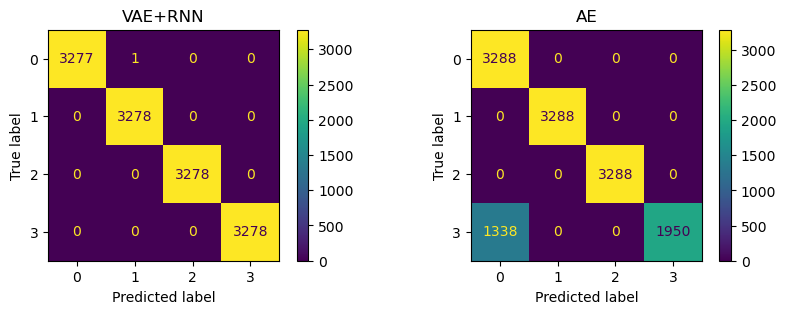

ROC Curve:


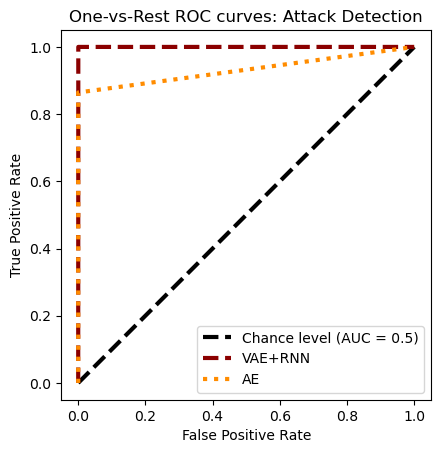

In [40]:
severity = 7
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   1.000000  0.999695  0.999847      3278
           1   0.999695  1.000000  0.999847      3278
           2   1.000000  1.000000  1.000000      3278
           3   1.000000  1.000000  1.000000      3278

    accuracy                       0.999924     13112
   macro avg   0.999924  0.999924  0.999924     13112
weighted avg   0.999924  0.999924  0.999924     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.558899  1.000000  0.717043      3288
           1   0.999391  0.998479  0.998935      3288
           2   1.000000  1.000000  1.000000      3288
           3   1.000000  0.211679  0.349398      3288

    accuracy                       0.802540     13152
   macro avg   0.889572  0.802540  0.766344     13152
weighted avg   0.889572  0.802540  0.766344     13152

Confusion Matrix:


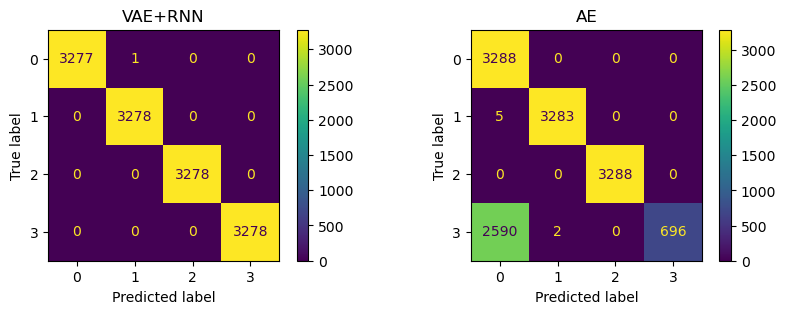

ROC Curve:


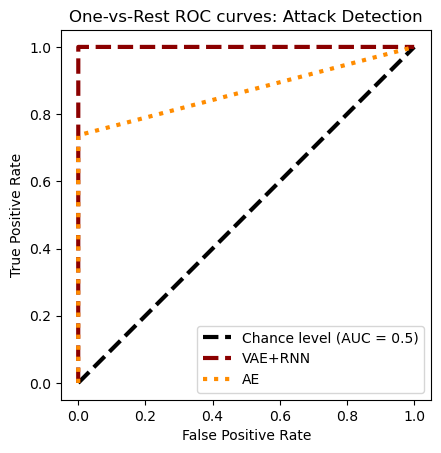

In [41]:
severity = 8
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.
classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

VAE+RNN --> DNN Classification Report: 
              precision    recall  f1-score   support

           0   0.957627  0.999695  0.978209      3278
           1   0.999695  0.999085  0.999390      3278
           2   1.000000  0.999695  0.999847      3278
           3   1.000000  0.956986  0.978020      3278

    accuracy                       0.988865     13112
   macro avg   0.989330  0.988865  0.988867     13112
weighted avg   0.989330  0.988865  0.988867     13112

AE --> DNN Classification Report:
              precision    recall  f1-score   support

           0   0.374658  1.000000  0.545093      3288
           1   0.987245  0.235401  0.380157      3288
           2   1.000000  0.128345  0.227493      3288
           3   0.096215  0.092762  0.094456      3288

    accuracy                       0.364127     13152
   macro avg   0.614529  0.364127  0.311800     13152
weighted avg   0.614529  0.364127  0.311800     13152

Confusion Matrix:


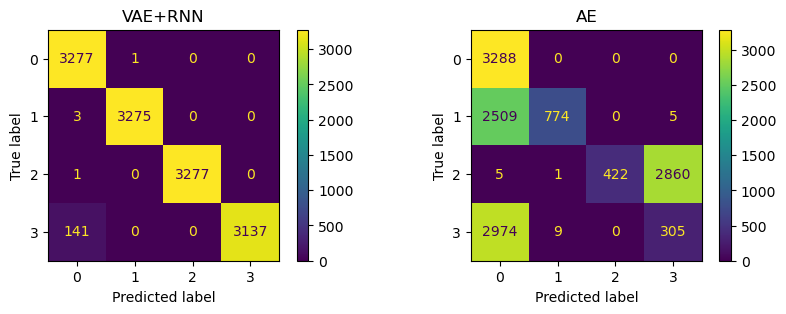

ROC Curve:


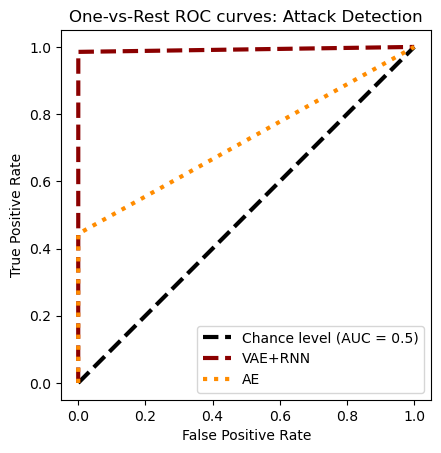

In [42]:
severity = 9
level = 50

pp_vae = torch.argmax(pred['vae'][level,severity], dim=1).numpy()
pp_ae = torch.argmax(pred['ae'][level,severity], dim=1).numpy()
yy_vae = torch.argmax(y['vae'], dim=1).numpy()
yy_ae = torch.argmax(y['ae'], dim=1).numpy()

# report
print("\033[1mVAE+RNN --> DNN Classification Report:\033[0m ")
print(metrics.classification_report(yy_vae, pp_vae, digits=6, zero_division=0))
print("\033[1mAE --> DNN Classification Report:\033[0m")
print(metrics.classification_report(yy_ae, pp_ae, digits=6, zero_division=0))

# confusion matrix
print("\033[1mConfusion Matrix:\033[0m")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
cm = metrics.confusion_matrix(yy_vae,pp_vae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[0])
cm = metrics.confusion_matrix(yy_ae,pp_ae, labels=[0,1,2,3])
metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot(ax=axes[1])
axes[0].set_title("VAE+RNN")
axes[1].set_title("AE")
plt.show()

# roc curve 0 vs. rest
print("\033[1mROC Curve:\033[0m")
chance_level_line_kw = {
            "label": "Chance level (AUC = 0.5)",
            "color": "k",
            "linestyle": "--",
            "lw": 3
        }
yy_vae[yy_vae>0] = 1
pp_vae[pp_vae>0] = 1
yy_ae[yy_ae>0] = 1
pp_ae[pp_ae>0] = 1
fpr_vae, tpr_vae, the_vae = metrics.roc_curve(yy_vae, pp_vae)
fpr_ae, tpr_ae, the_ae = metrics.roc_curve(yy_ae,pp_ae)
plt.plot((0, 1), (0, 1), **chance_level_line_kw)
plt.plot(fpr_vae, tpr_vae, lw=3, linestyle='dashed', color='darkred', label= "VAE+RNN")
plt.plot(fpr_ae, tpr_ae, lw=3, linestyle='dotted', color='darkorange', label= "AE")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Attack Detection")
plt.legend()
plt.show()

## **Quantiles**

In [45]:
q = torch.tensor([0.025, 0.975])
x_ax = ['0%', '%5', '%10', '%20', '50%']

### **Quantiles: Attack Severity 5**

In [46]:
severity = 5
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 39.73it/s]


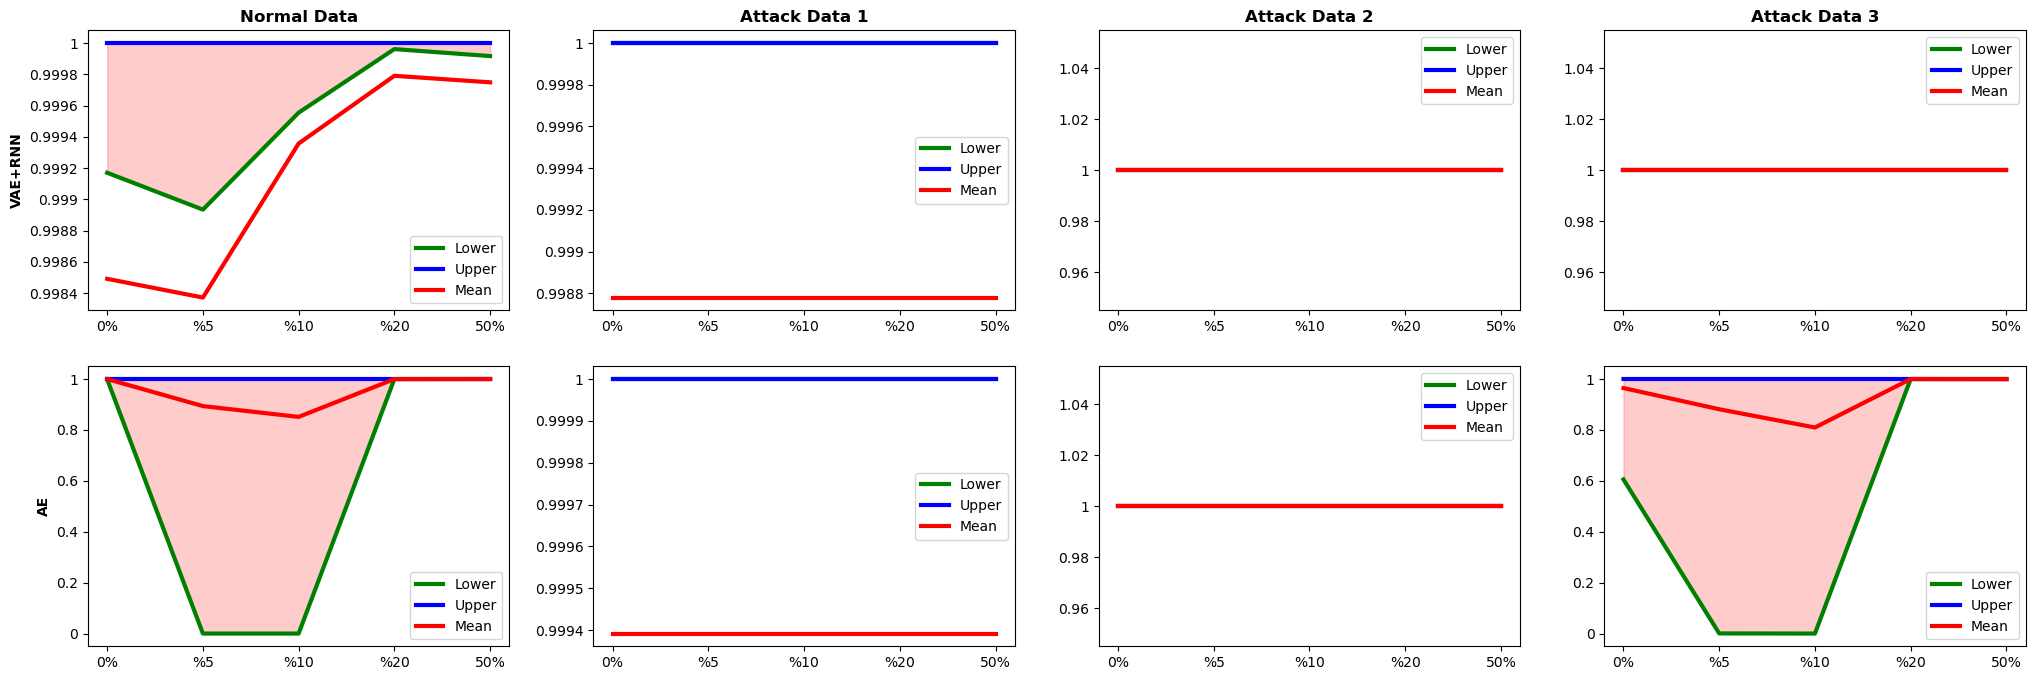

In [47]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 6**

In [48]:
severity = 6
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 50.67it/s]


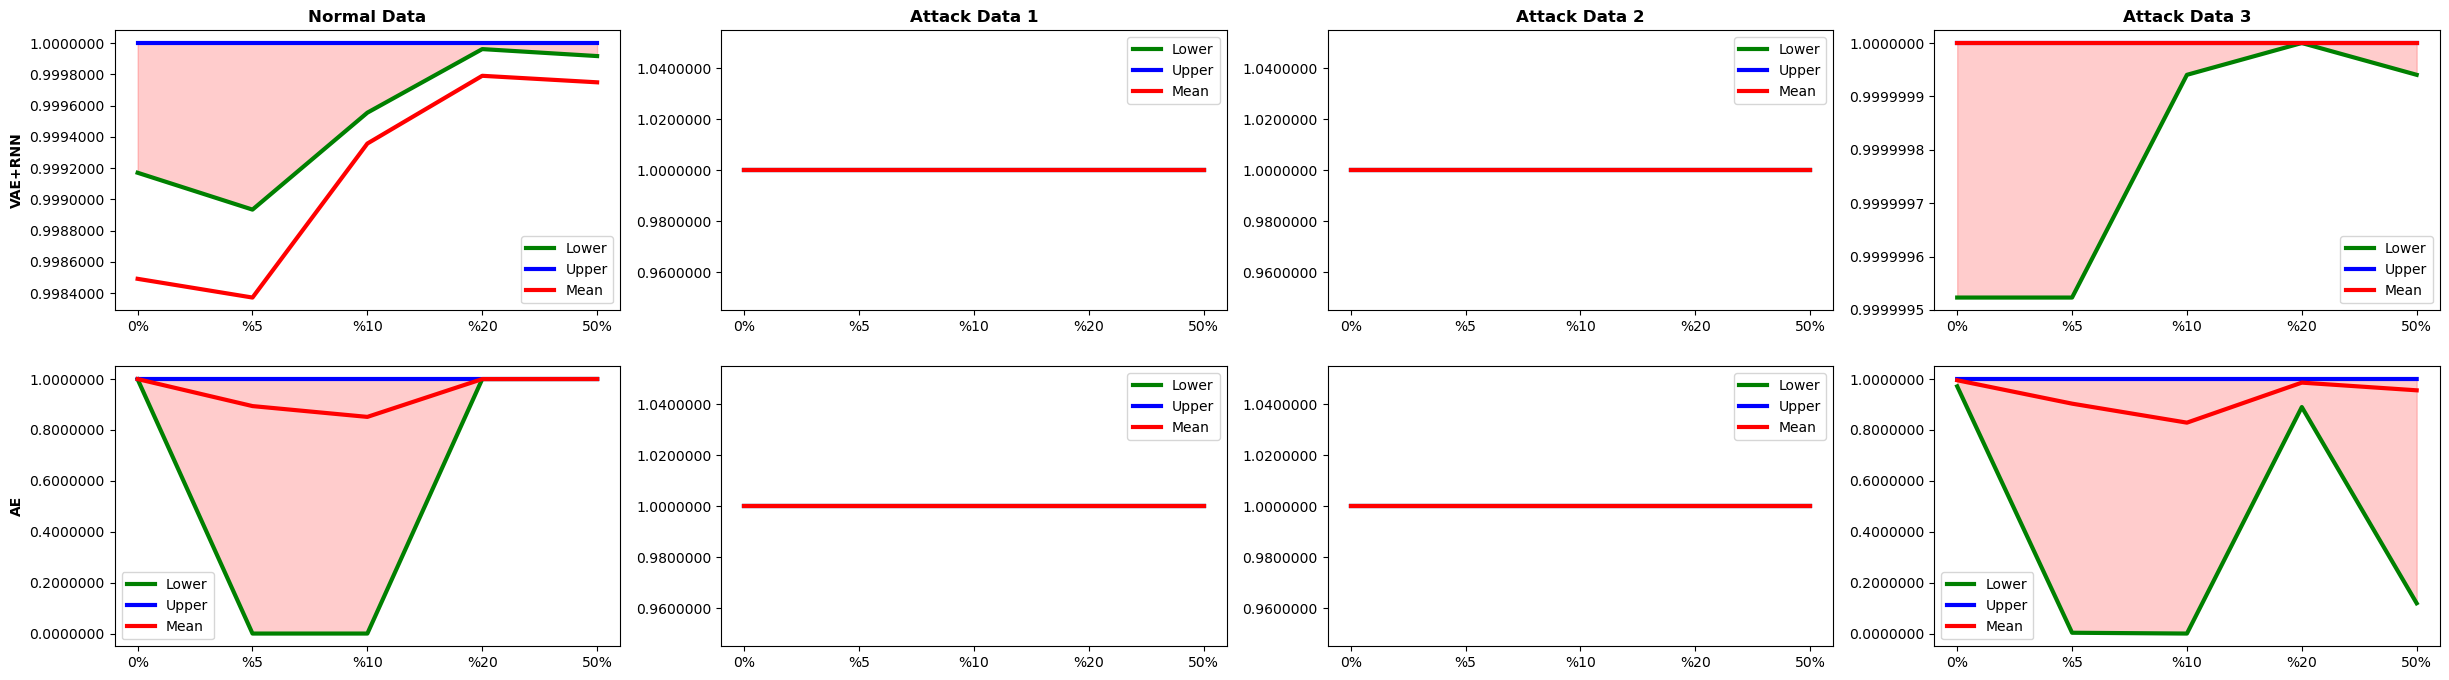

In [50]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.7f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 7**

In [51]:
severity = 7
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 31.09it/s]


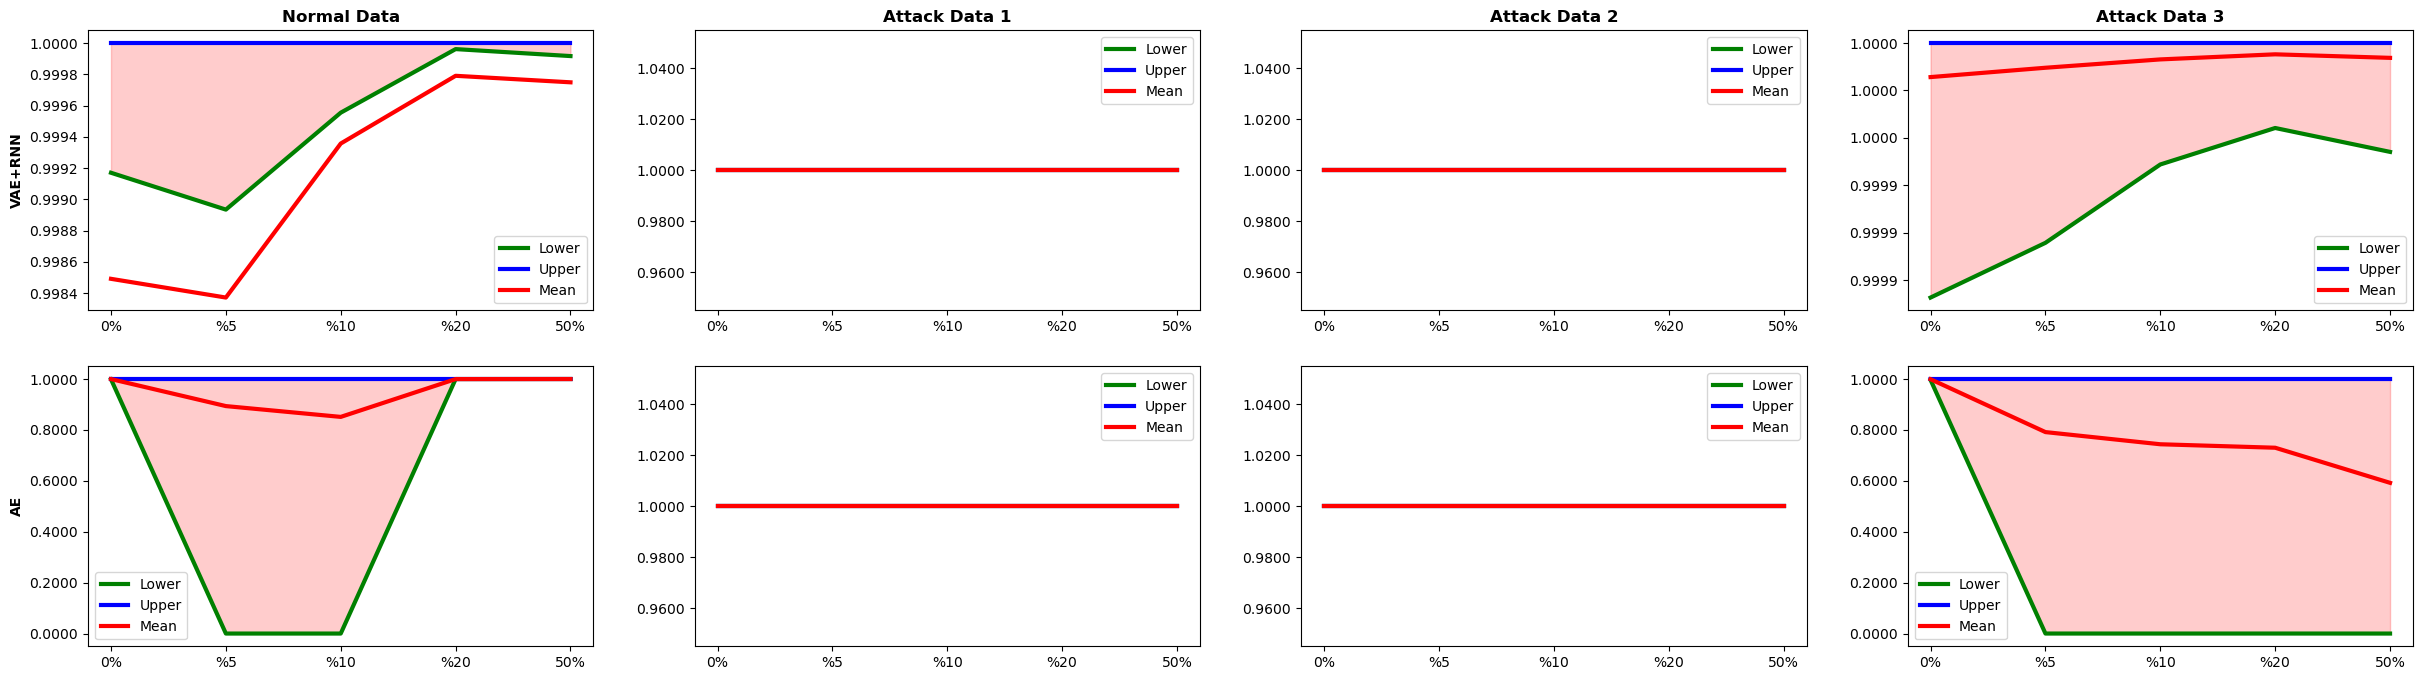

In [53]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 8**

In [54]:
severity = 8
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 36.21it/s]


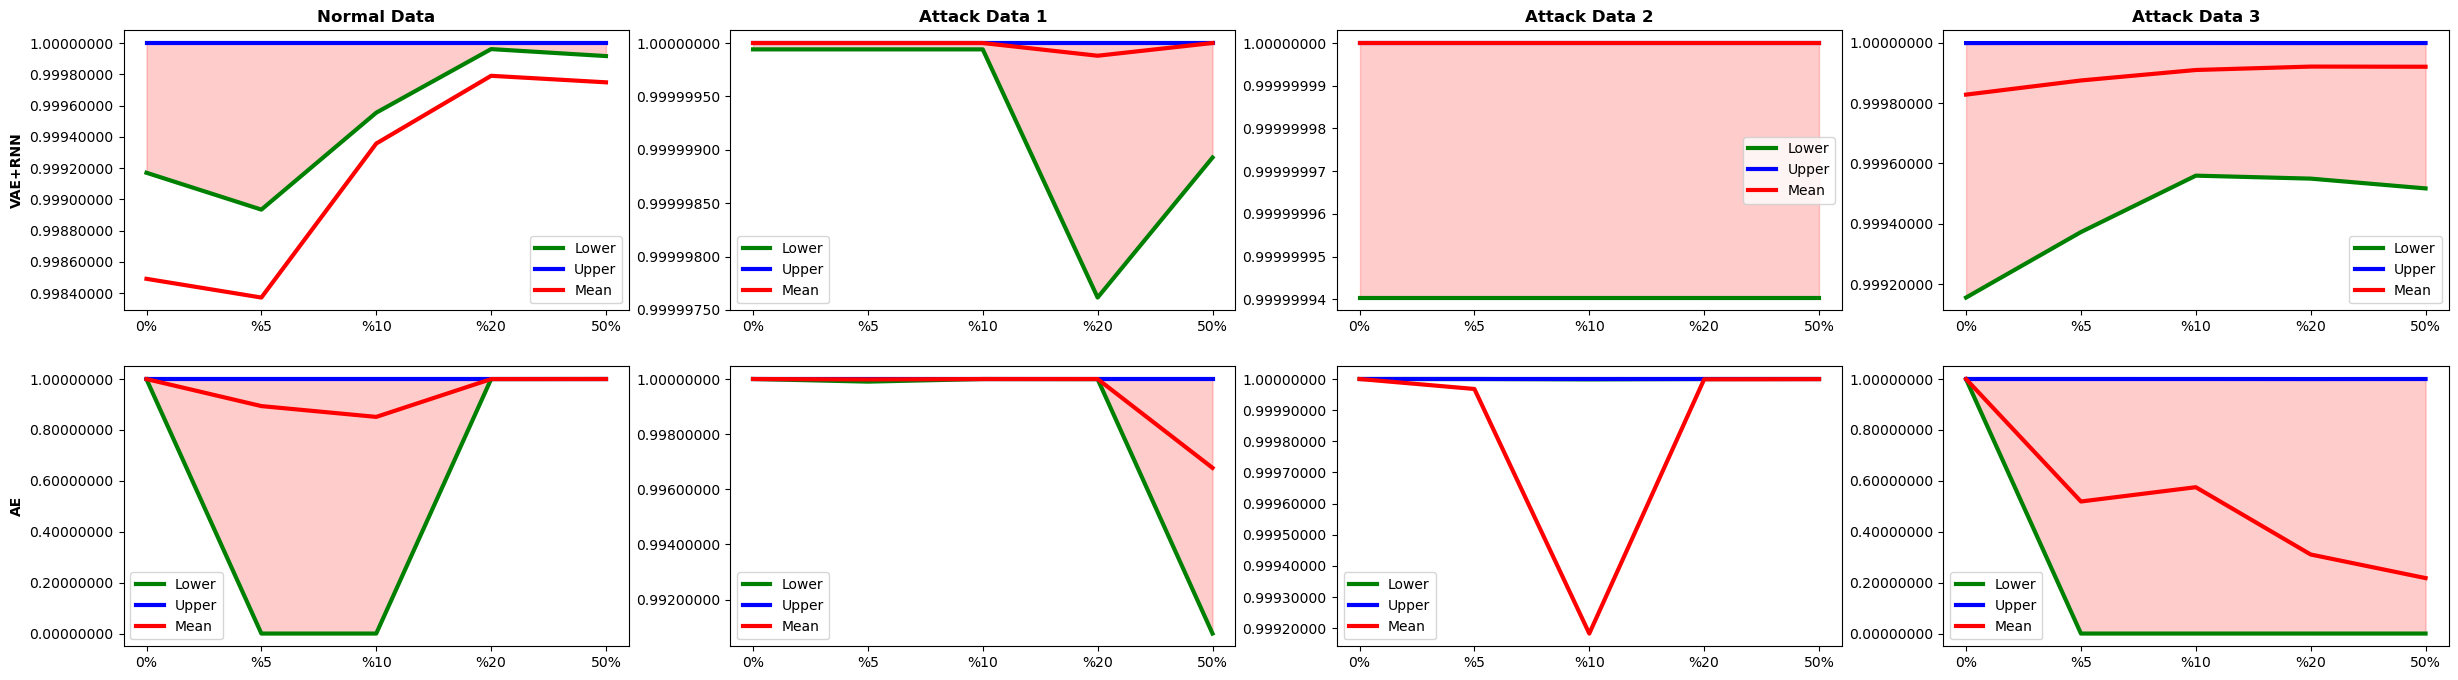

In [59]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(30, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%.8f'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

### **Quantiles: Attack Severity 9**

In [60]:
severity = 9
mean, low, up = defaultdict(dict), defaultdict(dict), defaultdict(dict)
_min, _max = defaultdict(dict), defaultdict(dict)
for k, v in tqdm(pred.items(),desc=' Generating quantiles ... '):
    for kk, vv in v.items():
        if kk[1] == severity:
            for _type in range(4):
                _pred = vv[_type * no_signal[k]:(_type + 1) * no_signal[k]]
                _min_val, _min_id = _pred.min(dim=0)
                _max_val, _max_id = _pred.max(dim=0)
                _min[k][kk[0],_type] = {_min_id[_type].item(): _min_val[_type].item()}
                _max[k][kk[0],_type] = {_max_id[_type].item(): _max_val[_type].item()}
                mean[k][kk[0],_type] = _pred.mean(dim=0).numpy()[_type]
                _low, _up = torch.quantile(_pred, q, dim=0).numpy()
                low[k][kk[0], _type], up[k][kk[0], _type] = _low[_type], _up[_type]

 Generating quantiles ... : 100%|██████████| 2/2 [00:00<00:00, 43.96it/s]


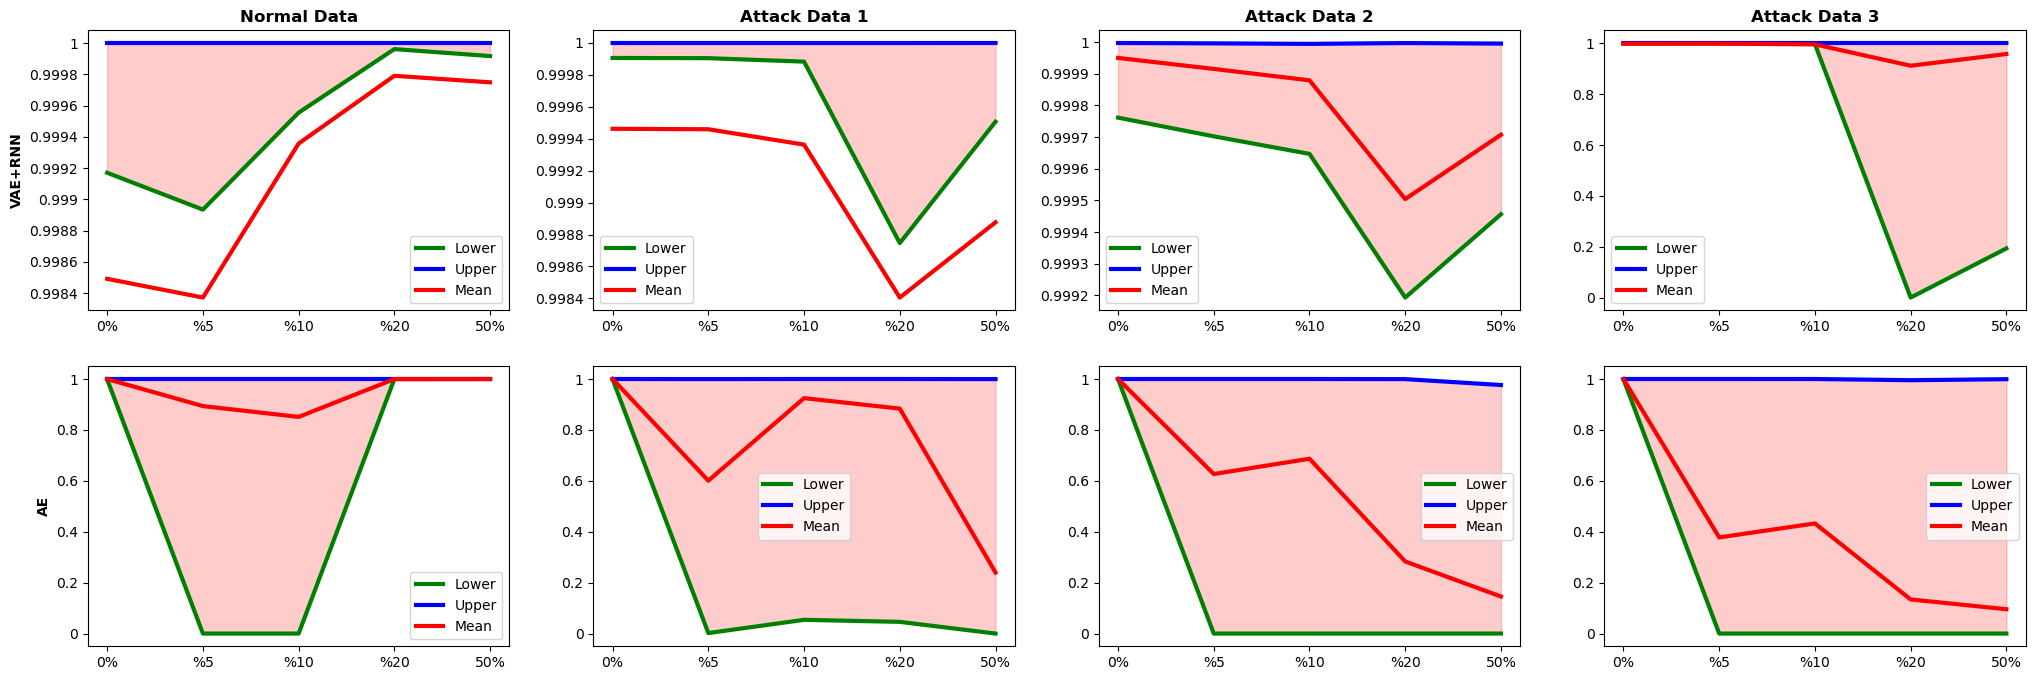

In [61]:
x = np.arange(len(noise_levels))
fig, ax = plt.subplots(2, 4, figsize=(25, 8))
_map = {'vae': 0, 'ae': 1}
for k in pred.keys():
    for _type in range(4):
        _m = [mean[k][l, _type] for l in noise_levels]
        _l = [low[k][l, _type] for l in noise_levels]
        _u = [up[k][l, _type] for l in noise_levels]
        ax[_map[k],_type].plot(x, _l, label='Lower', lw=3, color='g')
        ax[_map[k],_type].plot(x, _u, label='Upper', lw=3, color='b')
        ax[_map[k],_type].plot(x, _m, label='Mean', lw=3, color='r')
        ax[_map[k],_type].fill_between(x, _l, _u, color='r', alpha=0.2)
        ax[_map[k],_type].set(xticks=x, xticklabels=x_ax)
        ax[_map[k],_type].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        if _type == 0:
            ax[0,_type].set_title('Normal Data', fontweight='bold')
            ax[0,_type].set_ylabel('VAE+RNN', fontweight='bold', fontsize=10)
            ax[1,_type].set_ylabel('AE', fontweight='bold', fontsize=10)
        else:
            ax[0,_type].set_title(f'Attack Data {_type}', fontweight='bold')
        ax[_map[k],_type].legend()
plt.show()

## **Detection-Localozation Accuracy**

In [62]:
detection, localization = defaultdict(list), defaultdict(list)
for k in pred.keys():
    for severity in range(5,10):
        for level in noise_levels:
            pp = torch.argmax(pred[k][level,severity], dim=1).numpy()
            yy = torch.argmax(y[k], dim=1).numpy()
            localization[k, severity].append(metrics.accuracy_score(yy, pp))
            yy[yy>0] = 1
            pp[pp>0] = 1
            detection[k, severity].append(metrics.accuracy_score(yy,pp))

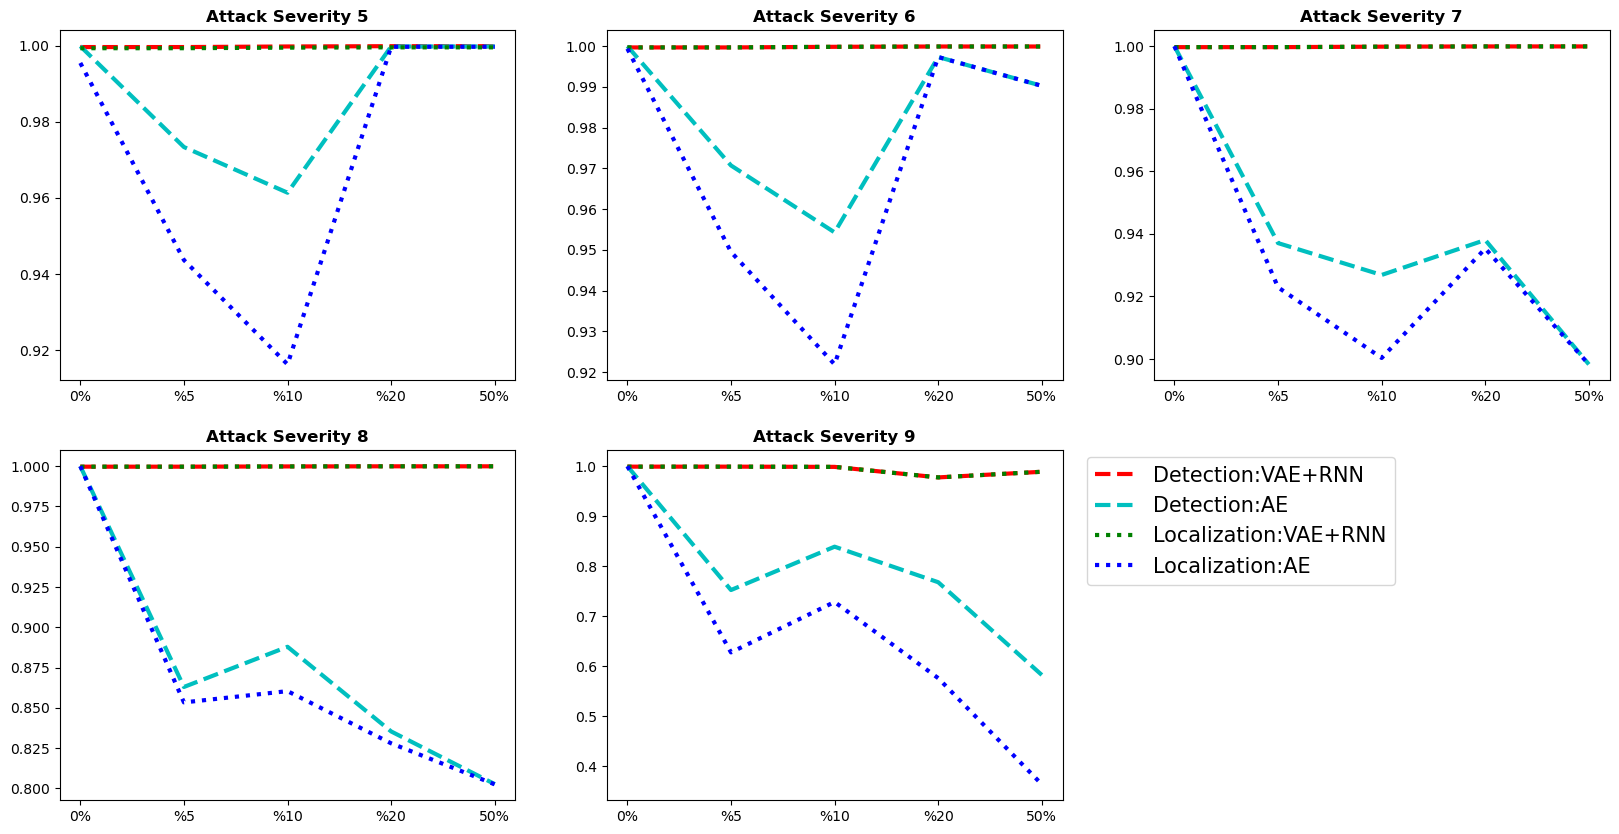

In [63]:
severity = list(range(5,10))
x = np.arange(len(noise_levels))
x_ax = ['0%', '%5', '%10', '%20', '50%']
fig, ax = plt.subplots(2,3, figsize=(20,10))
fig.delaxes(ax[1,2])
for s in severity:
    i = 0 if s < 8 else 1
    j = 0 if s < 8 else 3
    ax[i,s-5-j].plot(x, detection['vae',s], label='Detection:VAE+RNN', lw=3, linestyle="dashed", color='r')
    ax[i,s-5-j].plot(x, detection['ae',s], label='Detection:AE', lw=3, linestyle='dashed', color='c')
    ax[i,s-5-j].plot(x, localization['vae',s], label='Localization:VAE+RNN', lw=3, linestyle=":", color='g')
    ax[i,s-5-j].plot(x, localization['ae',s], label='Localization:AE', lw=3, linestyle=':', color='b')
    ax[i,s-5-j].set(xticks=x, xticklabels=x_ax)
    ax[i,s-5-j].set_title(f'Attack Severity {s}', fontweight='bold')
ax[1,1].legend(prop={'size': 15}, bbox_to_anchor=(1.03, 1.01))
plt.show()